In [1]:
%pylab nbagg
%load_ext autoreload

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


### Now what would fastCat think of this?

#### We can loop through this

In [6]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

dose = 1

phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
             'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

# phan_map_soft =  ['air','water','G4_ADIPOSE_TISSUE_ICRP','G4_BRAIN_ICRP',
#              'G4_LUNG_ICRP','G4_MUSCLE_SKELETAL_ICRP','G4_TISSUE_SOFT_ICRP','pmma']

spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO']#,'CuGOS_lowres']

phan_maps = [phan_map_hard]#,phan_map_soft]

angles = np.linspace(0,2*np.pi,90)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,360)

geo = 'catphan_low_contrast_512'

phantom = xg.Catphan_515(os.path.join(xg.data_path,f'phantoms/{geo}.npy'))

for phan_map in phan_maps:
    for spectrum_file in spectrum_files:
        for det in dets:
            s = xg.Spectrum()

            energies = []
            fluence = []

            with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
                for line in f:
                    energies.append(float(line.split()[0]))
                    fluence.append(float(line.split()[1]))
            
            # Check if MV

            s.x = np.array(energies)*1000  # to keV
            s.y = np.array(fluence)

            spectrum = xg.Spectrum()

            spectrum.x = energies
            spectrum.y = fluence

            dump_files = os.path.join(
                xg.data_path, "Detectors", det, '*phsp.npy')
            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

            kernel, kernels = xg.get_kernel(
                                    s, dump_files, energy_deposition_file)

            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')
            energies = s.x
            fluence = s.y
            deposition_efficiency_file = energy_deposition_file

            noise = xg.update_fluence(spectrum_file,dose)

            res.append(xg.return_projs(phantom.phantom,kernel,
                                       energies,fluence,angles,phantom.geomet,
                                       deposition_efficiency_file=deposition_efficiency_file
                                       ,phantom_mapping = phan_map,
                                       scaling=noise,
                                      dose=dose))

#             img_xg = tigre.algorithms.FDK(
#                 np.transpose(np.array(projs_xg[0]),[0,2,1]), phantom.geomet,angles)

#             res.append([[phan_map,spectrum_file,det],phantom.analyse_515(img_xg[5])])

(17,) (17,)
0.0006164371355334828
(17,) (17,)
0.003986048237744313


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


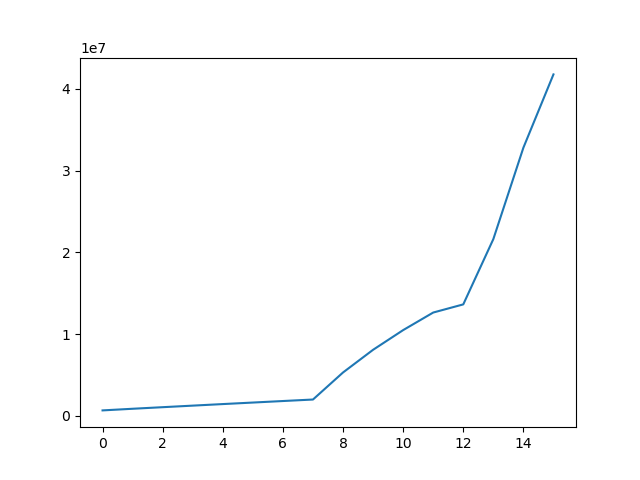

<IPython.core.display.Javascript object>


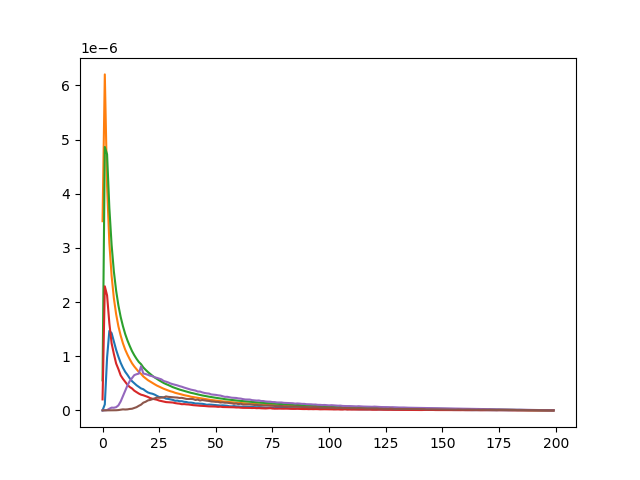

In [5]:
# plt.figure()
# plt.plot(res[0][0])

# plt.figure()
# plt.plot(res[0][1])
# plt.plot(res[1][1])
# plt.plot(res[2][1])
# plt.plot(res[3][1])
# plt.plot(res[4][1])
# plt.plot(res[5][1])

<IPython.core.display.Javascript object>


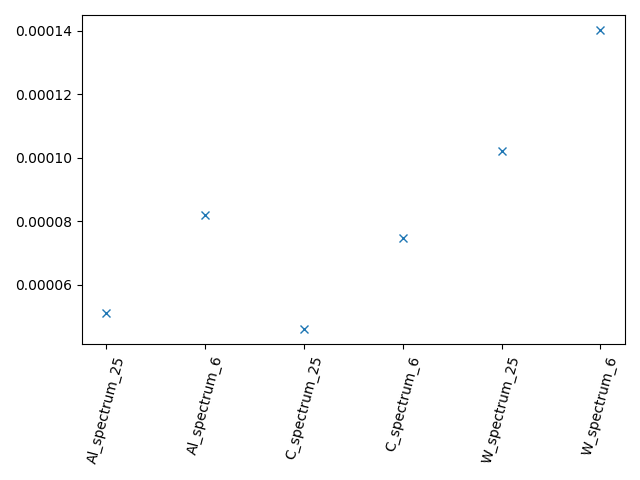

Al_spectrum_25
Al_spectrum_6
C_spectrum_25
C_spectrum_6
W_spectrum_25
W_spectrum_6


In [17]:
spectrum_files = sorted(['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25'])

plt.figure()

doses = res[0][0]
doses_fc = []

for jj,spectrum_file in enumerate(spectrum_files):
    
    print(spectrum_file)
    energies = []
    fluence = []

    with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
        for line in f:
            energies.append(float(line.split()[0]))
            fluence.append(float(line.split()[1]))

    # These are what I used in the Monte Carlo
    original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

    mu_en_water = np.array([0.1557, 0.06947,0.04223,0.03190,0.03800,0.02597,0.02554, 0.02546,0.03192,0.03299,0.03244,0.03150,0.03103,0.02608,0.02066,0.01806])

    # Loading the file from the monte carlo
    deposition_summed = np.load(deposition_efficiency_file,allow_pickle=True)

    # This is a scaling factor that I found to work to convert energy deposition to photon probability eta
    deposition_summed = deposition_summed[0]/(original_energies_keV*355)




    # Binning to get the fluence per energy
    large_energies = np.linspace(0,6000,3001)/1000
    fluence_large = np.interp(large_energies,np.array(energies), fluence)

    fluence_small = np.zeros(len(original_energies_keV))

    # Still binning
    for ii, val in enumerate(large_energies):

        index = np.argmin(np.abs(original_energies_keV-val*1000))
        fluence_small[index] += fluence_large[ii] 

    # Normalize
    fluence_small /= np.sum(fluence_small)

    # Sum over the image dimesions to get the energy intensity and multiply by fluence
    dose_divided_by_initial_intensity = doses@(fluence_small*mu_en_water)
    
    #plt.plot(jj,doses@(fluence_small*mu_en_water),'x')

    # Mass of the phantom there is a times 4 since the detector is 1/4 the size 1000 for mg
    dose_in_mgrays = dose_divided_by_initial_intensity*1.6021766e-13/2.0106*4*1000
    # Scale by the amount of photons hitting the detector
    
    doses_fc.append(dose_in_mgrays)

plt.plot(doses_fc,'x')    
plt.xticks(ticks=range(len(spectrum_files)),labels=spectrum_files,rotation=75)
plt.tight_layout()

In [19]:
doses = np.array([
1.613708349168519e-07,
1.313530049174005e-07,
6.200432949299284e-07,
3.304057543118688e-07,
2.999242099122057e-07,
3.515523019359534e-07,

])
names = np.array([
'Dose_Al_spectrum_25'  ,
'Dose_C_spectrum_25'  ,
'Dose_W_spectrum_6',
'Dose_Al_spectrum_6'  , 
'Dose_C_spectrum_6',
'Dose_W_spectrum_25'])
indeces = np.argsort([
'Dose_Al_spectrum_25'  ,
'Dose_C_spectrum_25'  ,
'Dose_W_spectrum_6',
'Dose_Al_spectrum_6'  , 
'Dose_C_spectrum_6',
'Dose_W_spectrum_25'])


names = names[indeces]
doses = doses[indeces]

<IPython.core.display.Javascript object>


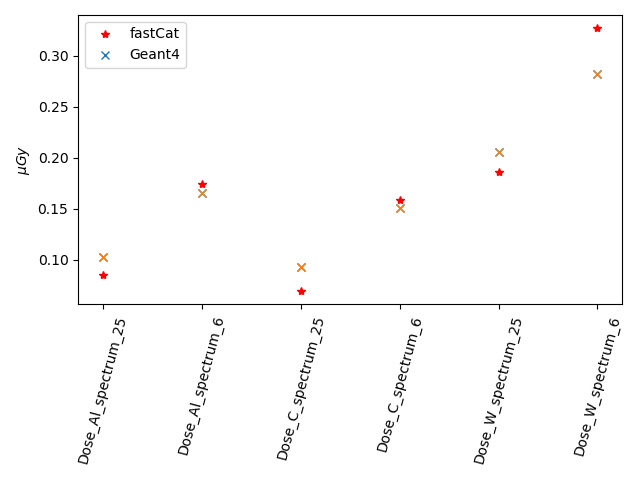

In [113]:
import pandas as pd

dat = pd.DataFrame(doses/sum(doses),index=names)

doses_fc2 = np.array(doses_fc)*np.log(2.8)

plt.figure()
plt.plot(dat,'r*')
plt.plot(doses_fc2/sum(doses_fc2),'x')
plt.plot(doses_fc/sum(doses_fc),'x')
plt.xticks(rotation=75)
plt.ylabel('$\mu Gy$')
plt.legend(['fastCat','Geant4'])
plt.tight_layout()

In [ ]:
plt.savefig('Dose Comparison')

In [38]:
from scipy.optimize import minimize

In [73]:
minimize(min_fun,1.8)

      fun: 0.11827329796689241
 hess_inv: array([[2.48758289e-08]])
      jac: array([4.65661287e-09])
  message: 'Optimization terminated successfully.'
     nfev: 231
      nit: 4
     njev: 77
   status: 0
  success: True
        x: array([0.9742189])

In [107]:
doses_fc_norm = np.array(doses_fc)/np.sum(doses_fc)
doses_norm = np.array(doses)/np.sum(doses)


def min_fun(x):
    
    return np.sum(np.abs((doses_fc_norm)-doses_norm))

In [108]:
x = 5

np.sum(np.abs(np.array(doses_fc)**x-np.array(doses)/np.sum(doses)))

1.0

In [109]:
min_fun(1.23)

0.7929858306156738

<IPython.core.display.Javascript object>


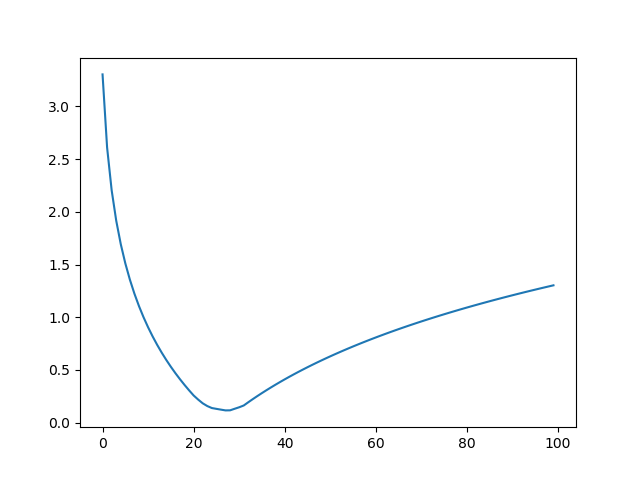

In [110]:
plt.figure()
plt.plot([min_fun(ii) for ii in np.linspace(0.1,10,100)])

In [111]:
np.linspace(0.1,10,100)[27]

2.8000000000000003